In [212]:
import copy
import enum
from typing import Callable
from typing import Mapping
from typing import Optional
from typing import Sequence
from typing import Tuple
from typing import TypeVar

import graphviz
import matplotlib.pyplot as plt
import torch
import tqdm

# Temporal-Difference Learning

## <p style="color:red">Text content copied near verbatim from: <a href="http://incompleteideas.net/book/the-book-2nd.html">Sutton and Barto</a>. Code is my own unless otherwise stated.</p>

## Key Concepts

- TD relation to Monte Carlo and DP methods.

## Definitions

**TD(0) / _n-step_ TD**: 

**TD error**:

**Markov Reward Process**:

## Notation

TODO

## Introduction

Temporal-difference (TD) learning is a combination of Monte Carlo ideas and dynamic programming (DP) ideas.

Like Monte Carlo methods, TD methods can directly learn from raw experience without a model of the environment's dynamics.

Like DP, TD methods update estimates based in part on other learned estimates, without waiting for a final outcome (they _bootstrap_).

DP, TD, and Monte Carlo methods all use some form of generalized policy iteration (GPI) to solve the control problem. The differences in the methods are primarily due to differences in their approaches to the prediction problem.

## TD Prediction

Both TD and Monte Carlo methods use experience to solve the prediction problem. Given some experience following a policy $\pi$, both methods update their estimate $V$ of $v_\pi$ for the nonterminal states $S_t$ occurring in that experience. 

---

Monte Carlo methods wait until the return following the visit is known, then use that return as a target for $V(S_t)$. A simple every-visit Monte Carlo method suitable for nonstationary environments is the _constant-$\alpha$ MC_:

\begin{equation}
    V(S_t) \leftarrow V(S_t) + \alpha \left[ G_t - V(S_t) \right]
\end{equation}

where $G_t$ is the actual return following time $t$ and $\alpha$ is a constant step-size parameter.

Monte Carlo methods must wait until the end of the episode to determine the increment to $V(S_t)$ (only then is $G_t$ known).

---

TD methods only need to wait until the next time step to determine the increment. At time $t + 1$ they immediately form a target and make a useful update using the observed reward $R_{t + 1}$ and the estimate $V(S_{t + 1})$. The simplest TD method makes the update

\begin{equation}
    V(S_t) \leftarrow V(S_t) + \alpha \left[ R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t) \right]
\end{equation}

immediately on transition to $S_{t + 1}$ and receiving $R_{t + 1}$. 

---

In effect, the target for the Monte Carlo update is $G_t$ whereas the target for the TD update is $R_{t + 1} + \gamma V(S_{t + 1})$. 

This TD method is called $TD(0)$ or _one-step_ TD because it is a special case of the TD($\lambda$) and _n-step_ TD methods developed in Chapters 12 and 7. 

In [50]:
StateT = TypeVar("StateT")
ActionT = TypeVar("ActionT")
RewardT = TypeVar("RewardT", int, float)

TraceT = Sequence[Tuple[StateT, ActionT, RewardT]]

In [206]:
def tabular_td0(
    policy: Mapping[StateT, Mapping[ActionT, float]],
    init_state: Callable[[], StateT],
    is_terminal: Mapping[StateT, bool],
    simulate: Callable[[StateT, ActionT], Tuple[StateT, RewardT]],
    n_episode: int,
    alpha: float = 0.1,
    gamma: float = 1.0,
    init_fn: Optional[Callable[[StateT], float]] = None
) -> None:
    state_values = {}
    
    for state in policy.keys():
        state_values[state] = 0 if init_fn is None else init_fn(state) 
        
    for _ in tqdm.trange(n_episode):
        state = init_state()
        
        while not is_terminal[state]:
            action = random.choices(
                population=list(policy[state].keys()), 
                weights=policy[state].values()
            )[0]   # random.choices returns a 1-element list
            next_state, reward = simulate(state, action)

            state_values[state] += alpha*(reward + gamma*state_values[next_state] - state_values[state])
            
            state = next_state
            
    return state_values

---

Confirming this works on the simple grid-world environment from Example 4.1 in Chapter 4:

In [107]:
gw_states: Sequence[int] = list(range(4*4))   # 4x4 grid, states numbered left to right top to bottom 

    
class GWAction(enum.Enum):
    UP    = enum.auto()
    DOWN  = enum.auto()
    RIGHT = enum.auto()
    LEFT  = enum.auto()

    
def gw_init_state() -> int:
    return random.choice(gw_states)


gw_is_terminal: Mapping[int, bool] = {
    state: state == 0 or state == 15
    for state in gw_states
}


def gw_simulate(state: int, action: GWAction) -> Tuple[int, float]:
    """
        
    """
    if action == GWAction.LEFT:
        if state % 4 == 0:
            #  unable to move further left
            return state, -1
        return state - 1, -1
    
    if action == GWAction.RIGHT:
        if (state + 1) % 4 == 0:
            # unable to move further right
            return state, -1
        return state + 1, -1
    
    if action == GWAction.UP:
        if state < 4:
            return state, -1
        return state - 4, -1
    
    if action == GWAction.DOWN:
        if state > 11:
            return state, -1
        return (state + 4) % 15, -1 

    raise ValueError(state, action)

In [108]:
gw_equiprob_policy = {}
for state in gw_states:
    gw_equiprob_policy[state] = {}
    for action in GWAction:
        gw_equiprob_policy[state][action] = 1.0 / len(GWAction)

In [124]:
state_values = tabular_td0(
    policy=gw_equiprob_policy,
    init_state=gw_init_state,
    is_terminal=gw_is_terminal,
    simulate=gw_simulate,
    n_episode=int(1e6),
    alpha=0.0001,
    gamma=1.0
)

100%|██████████| 1000000/1000000 [00:45<00:00, 22136.10it/s]


In [125]:
for i in range(4):
    for j in range(4):
        print(f"{state_values[i*4 + j]: 7.3f}", end=' ')
    print()

  0.000 -14.090 -20.001 -21.981 
-13.972 -18.012 -19.994 -19.978 
-19.946 -19.995 -17.980 -14.001 
-21.984 -20.044 -14.042   0.000 


Recall that the actual state-value function for this problem is:

```
| 0.0 | -14 | -20 | -22 |
| -14 | -18 | -20 | -20 |
| -20 | -20 | -18 | -14 |
| -22 | -20 | -14 | 0.0 |
```

so we see that the method works!

Notice that $\alpha$ must be small for the computed values to get close to their true value.

---

TD(0) bases its update in part on an existing estimate so it is a _bootstrapping_ method like DP. We know from Chapter 3 that:

\begin{align}
    v_\pi(s) &\doteq \mathbb{E}_\pi \left[ G_t | S_t = s \right] \\
             &= \mathbb{E}_\pi \left[ R_{t + 1} + \gamma G_{t + 1} | S_t = s \right] \\
             &= \mathbb{E}_\pi \left[ R_{t + 1} + \gamma v_\pi(S_{t + 1}) | S_t = s \right]
\end{align}

Monte Carlo methods use an estimate of $\mathbb{E}_\pi[G_t | S_t = s]$ as the target. It is an estimate as the expected value is not known; a sample return is used in place of the real expected return.

DP methods use an estimate of $\mathbb{E}_\pi[R_{t + 1} + \gamma v_\pi(S_{t + 1}) | S_t = s]$ as the target. It is an estimate not because of the expected values, which are assumed to be completely provided by a model of the environment, but because $v_\pi(S_{t + 1})$ is not known and the current estimate $V(S_{t + 1})$ is used instead.

The TD target is an estimate for both reasons:

1. It samples the expected values.
2. It uses the current estimate $V$ instead of the true $v_\pi$.

**TD methods combine the sampling of Monte Carlo with the bootstrapping of DP.**

---

Note that in the update rule for TD the quantity in brackets, $\left[ R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t) \right]$, is a sort of error measuring the difference between the estimated value of $S_t$ and the better estimate $R_{t + 1} + \gamma V(S_{t + 1})$. This is called the **TD error** and arises in various forms throughout reinforcement learning:

\begin{equation}
    \delta_t \doteq R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t)
\end{equation}

This quantity depends on the next state and reward so is not available until one time step later. If the array V does not change during the episode (e.g. Monte Carlo methods) then the Monte Carlo error can be written as a sum of TD errors:

\begin{align}
    G_t - V(S_t) &= R_{t + 1} + \gamma G_{t + 1} - V(S_t) \\
                 &= R_{t + 1} + \gamma G_{t + 1} - V(S_t) + \gamma V(S_{t + 1}) - \gamma V(S_{t + 1}) \\
                 &= \delta_t + \gamma \delta_{t + 1} + \gamma^2(G_{t + 2} - V(S_{t + 2})) \\
                 &= \delta_t + \gamma \delta_{t + 1} + \gamma^2\delta_{t + 2} + \dots + \gamma^{T - t - 1} \delta_{T - 1} + \gamma^{T - t}(0 - 0) \\
                 &= \sum_{k = t}^{T - 1} \gamma^{k - t} \delta_k
\end{align}

---

Exercise 6.1: If V changes during the episode then the above only holds approximately; what would the difference be between the two sides? Let $V_t$ denote the array of state values used at time $t$ in the TD error and in the TD update. Redo the derivation above to determine the additional amount that must be added to the sum of TD errors in order to equal the Monte Carlo error.

\begin{align}
    V_{t + 1}(S_t) &= V_t(S_t) + \alpha [R_{t + 1} + \gamma V_t(S_{t + 1}) - V_t(S_t)] \\
                   &= V_t(S_t) + \alpha [R_{t + 1} + \gamma V_t(S_{t + 1}) - V_t(S_t)] \\
                   &= V_t(S_t) + \alpha \delta_t \\
\end{align}

Rearranging for $V_t(S_t)$

\begin{align}
    V_t(S_t) &= V_{t + 1}(S_t) - \alpha \delta_t
\end{align}

Following through with the proof similar to the steps in (6.6):

\begin{align}
    G_t - V_t(S_t) &\doteq R_{t + 1} + \gamma G_{t + 1} - V_t(S_t) \\
                   &=      R_{t + 1} + \gamma V_t(S_{t + 1}) - V_t(S_t) + \gamma G_{t + 1} - \gamma V_t(S_{t + 1}) \\
                   &= \delta_t + \gamma(G_{t + 1} - V_t(S_{t + 1})) \\
                   &= \delta_t + \gamma(G_{t + 1} - V_{t + 1}(S_{t + 1}) + \alpha \delta_t) \\
                   &= \delta_t + \gamma \alpha \delta_t + \gamma(G_{t + 1} - V_{t + 1}(S_{t + 1})) \\
                   &= \delta_t(1 + \gamma \alpha) + \gamma(G_{t + 1} - V_{t + 1}(S_{t + 1})) \\
                   &= \delta_t(1 + \gamma \alpha) + \gamma(\delta_{t + 1}(1 + \gamma \alpha) + \gamma(G_{t + 2} - V_{t + 2}(S_{t + 2}))) \\
                   &= \delta_t(1 + \gamma \alpha) + \gamma(\delta_{t + 1}(1 + \gamma \alpha)) + \gamma(G_{t + 2} - V_{t + 2}(S_{t + 2})) \\
                   &= (1 + \gamma \alpha)(\delta_t + \gamma\delta_{t + 1}) + \gamma^2(\delta_{t + 2}(1 + \gamma \alpha) + \gamma(G_{t + 3} - V_{t + 3}(S_{t + 3}))) \\
                   &= (1 + \gamma \alpha)(\delta_t + \gamma\delta_{t + 1}) + \gamma^2\delta_{t + 2}(1 + \gamma \alpha) + \gamma^3(G_{t + 3} - V_{t + 3}(S_{t + 3})) \\
                   &= (1 + \gamma \alpha)(\delta_t + \gamma\delta_{t + 1} + \gamma^2\delta_{t + 2}) + \gamma^3(G_{t + 3} - V_{t + 3}(S_{t + 3})) \\
                   &= (1 + \gamma \alpha)\sum_{k=t}^{T - 1}\gamma^{k - t} \delta_t 
\end{align}

Intuitively this makes sense.

To see why, first note that the original equation _without_ the time subscript telescopes to produce the sum of discounted rewards equation. This is a convoluted way of getting from the RHS back to the LHS :-)

\begin{equation}
    \delta_t \doteq R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t)
\end{equation}


\begin{align}
    G_t - V(S_t) &= \sum_{k = t}^{T - 1} \gamma^{k - t} \delta_k \\
                 &= R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t) + \gamma ( R_{t + 2} + \gamma V(S_{t + 2}) - V(S_{t + 1})) + \sum_{k = t + 2}^{T - 1} \gamma^{k - t} \delta_k \\
                 &= R_{t + 1} + \gamma V(S_{t + 1}) - V(S_t) + \gamma R_{t + 2} + \gamma^2 V(S_{t + 2}) - \gamma  V(S_{t + 1}) + \sum_{k = t + 2}^{T - 1} \gamma^{k - t} \delta_k \\
                 &= R_{t + 1} + \gamma R_{t + 2} - V(S_t) + \gamma^2 V(S_{t + 2})+ \sum_{k = t + 2}^{T - 1} \gamma^{k - t} \delta_k \\
                 &= \left[\sum_{k = t + 1}^{T} \gamma^{k - t - 1}R_{k}\right] - V(S_t)
\end{align}

Now, from the above we also know:

\begin{equation}
    V_{t + 1}(S_t) - V_t(S_t) = \alpha \delta_t
\end{equation}

Distributing the summation gives:

\begin{align}
    G_t - V_t(S_t) &= (1 + \gamma \alpha) \sum_{k = t}^{T - 1} \gamma^{k - t}\delta_t \\
                   &= \sum_{k = t}^{T - 1} \gamma^{k - t}\delta_t + \gamma \alpha \sum_{k = t}^{T - 1} \gamma^{k - t}\delta_t \\
                   &= \sum_{k = t}^{T - 1} \gamma^{k - t}\delta_t + \sum_{k = t}^{T - 1} \gamma^{k - t + 1} \alpha \delta_t \\
                   &= \sum_{k = t}^{T - 1} \gamma^{k - t} \delta_t + \gamma^{k - t + 1} \alpha \delta_t
\end{align}

It is the original sum of discounted TD errors plus another term. This other term accounts for the sum of discounted differences/deltas between the state-value estimate at step $t + 1$ and at step $t$. i.e. it is the difference, $\alpha \delta_k$, weighted by the discounting factor.

---

Example 6.1: Driving Home (/Exercise 6.2)

Consider driving home and at various points estimating the time remaining. This can be considered an RL problem where the state is the weather, your location, current time etc. The rewards are the negated time taken to get to the point on your journey home. The value function is the negated estimate of how long you think it should take to get home from the current state.

Let $\gamma = 1$ and $\alpha = 1$. 

For Monte Carlo methods the error, $G_t - V(S_t)$ is the difference between the actual time taken and the estimated time remaining. This requires knowing how long the journey took in total so updates can only be done offline. It also means that changes that occur in just one state can have big impacts as to the predicted times of all other states, even if in practice they are unchanged. 

For methods that use temporal difference learning the error is $R_t + \gamma V(S_{t + 1}) - V(S_t)$. The estimated return, in this case time remaining, can be updated as soon as the next state and reward are known. In the case of driving home, if you predict it will take 30 minutes to get home and it takes 5 minutes to reach the next state where you now think it will take 20 minutes, the prior estimate can be updated by $5 + 20 - 30 = -5$ minutes _without_ needing to actually reach your house.

Note that this means if your next state has an accurate estimate of the time taken to reach home then you are able to quickly converge the current state's estimate to the true expected value. Consider changing jobs to one that is in a different location but after a slightly different, longer start uses the same route home. For MC Methods the error for all states will initially be increased despite it only being the few starting states that have changed and they will need to be decreased again as the starting states converge.For TD methods only these initial states will be updated. 

--- 

### Advantages of TD Prediction Methods

**Bootstrap**: Learning to guess from a guess. TD methods update their estimates based in part on other estimates.

TD Method Advantages:

1. Compared to DP methods, they do not require a model of the environment (DP methods use to compute expectation over all possible next states and rewards). 
2. Compared to Monte Carlo methods, they can be implemented in an online, fully incremental fashion (Monte Carlo methods must wait until the end of the episode to get the final reward). Some applications have very long episodes where delaying all learning until the end of the episode is too slow. Other applications have no episodes at all! 
3. Compared to Monte Carlo methods, TD methods can learn from each transition regardless of what subsequent actions are taken. Some Monte Carlo methods must ignore or discount episodes on which experimental actions are taken, which can greatly slow learning (if action is non-greedy towards end of episode, importance sampling ratio is zero and therefore all updates at time before the step become zero).


Convergence can be guaranteed for TD methods: for any fixed policy $\pi$, $TD(0)$ has been proved to converged to $v_\pi$. In the mean for a constant step size parameter if it is sufficiently small or with probability 1 if it decreases. 


It is an open question as to which of Monte Carlo or TD methods are more data efficient/learns faster. In practice TD methods have usually been found to converge faster than constant-$\alpha$ MC methods on stochastic tasks.

---

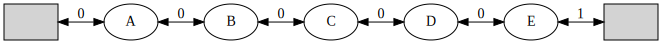

In [142]:
# Example 6.2: Random Walk

# A Markov reward process (MRP) is a MDP without actions.
#
# MRPs are often useful when focusing on the prediction problem is which there is no need
# to distinguish between the dynamics due to the environment and those due to the agent.
# (i.e. the state->action, action->next state probabilities collapse to state->next state)
#
# Consider the MRP:

g = graphviz.Digraph(graph_attr={"rankdir": "LR"})

nodes = [
    "endL", "A", "B", "C", "D", "E", "endR"
]
for n in nodes:
    end = "end" in n
    g.node(
        n,
        label=None if not end else "",
        shape="box" if end else None,
        style="filled" if end else None,
    )
    
for l, r in zip(nodes, nodes[1:]):
    g.edge(
        l, r,
        dir="both", 
        label="0" if r != "endR" else "1"
    )
    
g

In [ ]:
# The starting state is always C and it proceeds left or right both with probability 0.5 until
# either end state is reaching. The reward is always 0 except when the episode terminates on
# the right where it is +1. 

In [145]:
class RandWalkAction(enum.Enum):
    LEFT = enum.auto()
    RIGHT = enum.auto()

In [162]:
TERMINAL = "."
rnd_walk_state_idxs = {
    s: i for i, s in enumerate([TERMINAL] + list("ABCDE"))
}
rnd_walk_states = list(rnd_walk_state_idxs.values())

rnd_walk_policy = {
    k: {a: 0.5 for a in RandWalkAction}
    for k in rnd_walk_states
}

rnd_init_state = lambda: rnd_walk_state_idxs["C"]

rnd_is_terminal = {
    s: s == rnd_walk_state_idxs[TERMINAL] 
    for s in rnd_walk_states
}

def rnd_simulate(state, action):
    if state == rnd_walk_state_idxs[TERMINAL]:
        return rnd_walk_state_idxs[TERMINAL], 0
    
    if action == RandWalkAction.LEFT:
        return state - 1, 0
    
    if state == rnd_walk_state_idxs["E"] and action == RandWalkAction.RIGHT:
        return rnd_walk_state_idxs[TERMINAL], 1
    
    return state + 1, 0

In [202]:
def run_rnd_td0(n_episode):
    return tabular_td0(
        policy=rnd_walk_policy,
        init_state=rnd_init_state,
        is_terminal=rnd_is_terminal,
        simulate=rnd_simulate,
        n_episode=n_episode,
        alpha=0.1,
        gamma=1.0,
        init_fn=lambda s: 0.0 if s == rnd_walk_state_idxs[TERMINAL] else 0.5
    )

0it [00:00, ?it/s]
100%|██████████| 100/100 [00:00<00:00, 45353.63it/s]


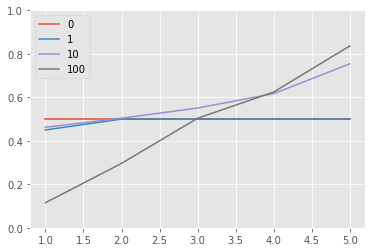

In [219]:
plt.style.use("ggplot")

to_plot = copy.deepcopy(rnd_walk_states)
to_plot.remove(rnd_walk_state_idxs[TERMINAL])

for n_episode in [0, 1, 10, 100]:
    state_values = run_rnd_td0(n_episode)
    plt.plot(
        to_plot, 
        [state_values[s] for s in to_plot],
        label=f"{n_episode}",
    )
    
plt.ylim(0, 1)
plt.legend()
plt.show()